# Propagation using Non-Orthogonal Radiation Modes

To test if the integral coefficient system is set up right, here we use non-orthogonal radiation modes and knowledge of the integral system to propagate input fields.  This requires extracting A(Z) and B(Z) from the non-diagonal system.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from slab import SlabExact
from scipy.linalg import eig
from fiberamp.fiber.microstruct.bragg import plotlogf, plotlogf_real
from scipy.integrate import quad
from scipy.optimize import newton

%matplotlib widget

In [2]:
# A = SlabExact(ns=[1.44, 1.45, 1.44], ts=[2e-6, 2e-6, 2e-6], symmetric=True)

A = SlabExact(ns=[1.44, 1.45, 1.46, 1.44], ts=[2e-6, 2e-6, 2e-6, 2e-6], xrefs=[100,100,100,100],symmetric=True)

In [3]:
# def f0(x):
#     conds = [(x<-1), ((-1<=x)*(x<=1)), (x>1)]
#     funcs = [0, lambda x: 1-x**2, 0]
#     return np.piecewise(x, conds, funcs)

def f0(x):
    conds = [(x<-1), ((-1<=x)*(x<=1)), (x>1)]
    funcs = [0, lambda x: (1-x)*(1-x**2), 0]
    return np.piecewise(x, conds, funcs)


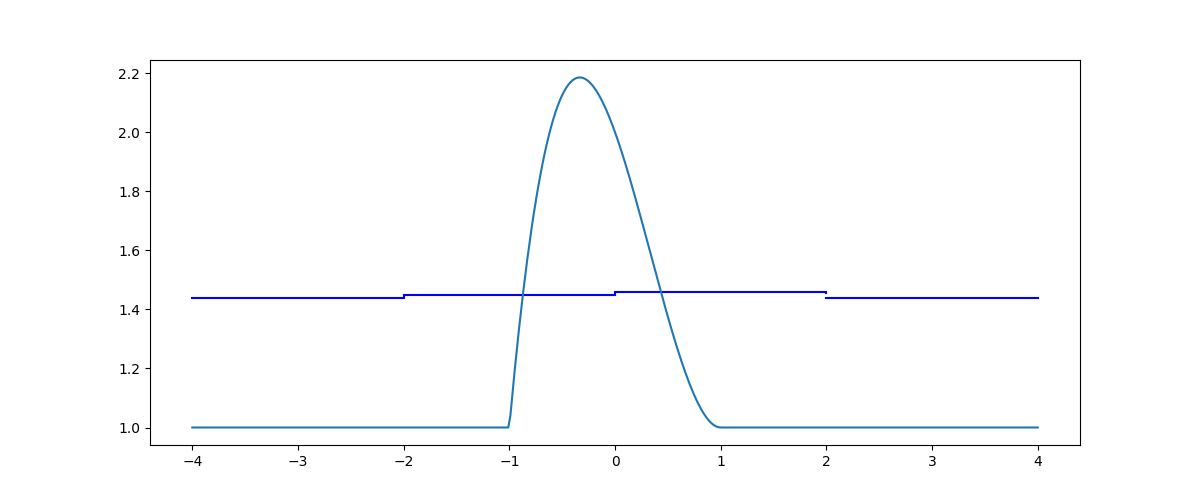

In [4]:
A.plot_refractive_index()
A.add_1d_plot(lambda x: f0(x) +1)

## Guided modes

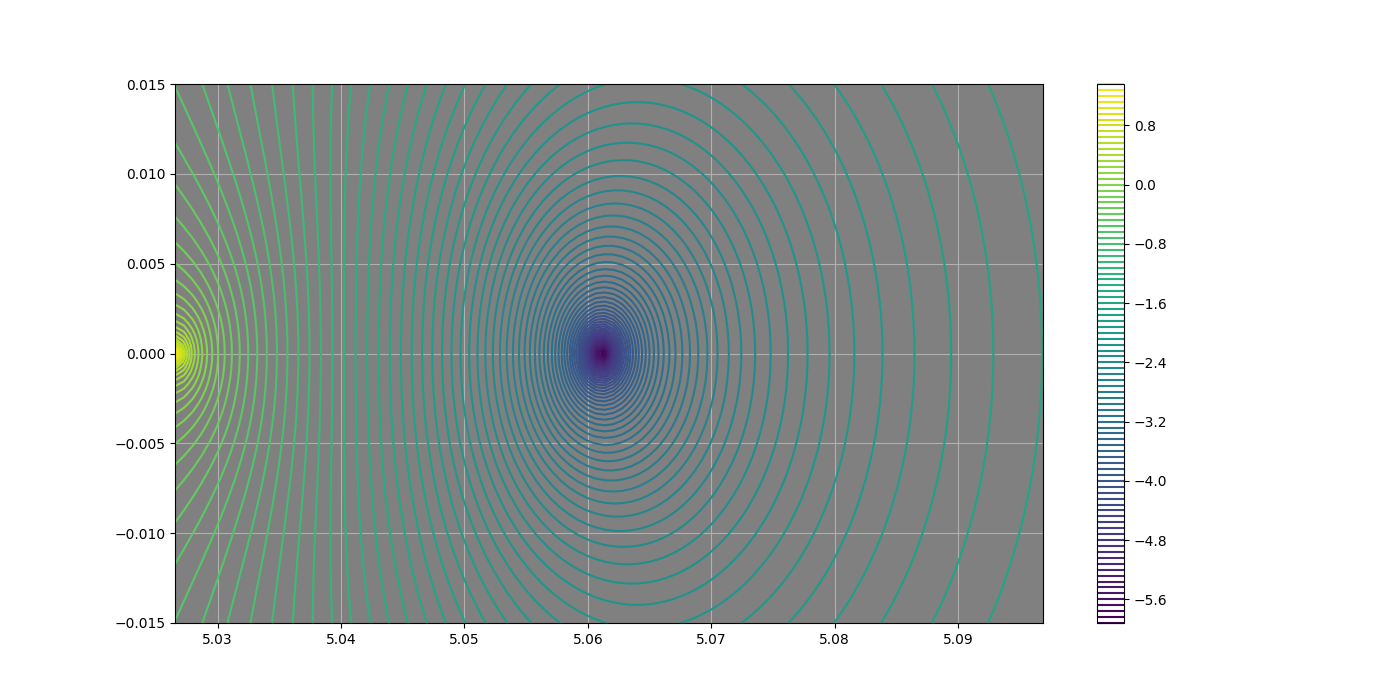

In [5]:
plotlogf(A.determinant, A.K_low, 1.0001*A.K_high, -.015, .015, 'TE', 'guided', 
         iref=100, rref=100, levels=100)

In [6]:
beta = newton(A.determinant, 5.05, args=('TE', 'guided'))
Fg = A.fields(beta, field_type='TE', mode_type='guided')


In [7]:
integrand = lambda x: Fg(x) * Fg(x).conjugate()
cf1 = quad(integrand, -75, 75, complex_func=True)[0].real

integrand = lambda x: f0(x) * Fg(x).conjugate()
cf2 = quad(integrand, -1,1, complex_func=True)[0].real

alpha = cf2/cf1

# Propagation

In [8]:
A.Z_evanescent

5.026548245743669

### Non-Orthogonal

In [9]:
S = np.array([[0, 1], [1, 0]])

xs = np.linspace(-5, 5, 800)
zs = np.linspace( 0, 8, 800)
Ys_no = np.zeros((len(zs), len(xs)), dtype=complex)
ys_no = np.zeros(len(xs), dtype=complex)

Zs = np.linspace(0.00001, 20, 100)

f_As_no = np.zeros_like(Zs,dtype=complex)
f_Bs_no = np.zeros_like(Zs,dtype=complex)
C_As_no = np.zeros_like(Zs,dtype=complex)
C_Bs_no = np.zeros_like(Zs,dtype=complex)

dZ = Zs[1] - Zs[0]

for i,Z in enumerate(Zs):
    
    Fa = A.fields(Z, c0=1, c1=1, Z_plane=True, mode_type='radiation')
    Fb = A.fields(Z, c0=1+2j, c1=1-2j, Z_plane=True, mode_type='radiation')
    Ca = A.coefficients(Z, c0=1, c1=1, Z_plane=True, mode_type='radiation').T
    Cb = A.coefficients(Z, c0=1+2j, c1=1-2j, Z_plane=True, mode_type='radiation').T

    # Fa = A.fields(Z, c0=1, c1=1, Z_plane=True, mode_type='radiation')
    # Fb = A.fields(Z, c0=1, c1=1, Z_plane=True, mode_type='radiation', sign='-1')
    # Ca = A.coefficients(Z, c0=1, c1=1, Z_plane=True, mode_type='radiation').T
    # Cb = A.coefficients(Z, c0=1, c1=1, Z_plane=True, mode_type='radiation', sign='-1').T
    
    Naa = (Ca[0].T @ S @ Ca[0] + Ca[-1].T @ S @ Ca[-1])
    Nbb = (Cb[0].T @ S @ Cb[0] + Cb[-1].T @ S @ Cb[-1])
    Nab = (Ca[0].T @ S @ Cb[0] + Ca[-1].T @ S @ Cb[-1])
    detN = (Naa * Nbb - Nab**2)

    f_A = quad(lambda x: f0(x) * Fa(x), -1, 1,  complex_func=True)[0]
    f_B = quad(lambda x: f0(x) * Fb(x), -1, 1,  complex_func=True)[0]
    
    C_A = 1/(np.pi*detN) * (f_A * Nbb - f_B * Nab) 
    C_B = 1/(np.pi*detN) * (-f_A * Nab + f_B * Naa)
    
    f_As_no[i], f_Bs_no[i] = f_A, f_B
    C_As_no[i], C_Bs_no[i] = C_A, C_B

    Ys_no += (C_A * Fa(xs, zs) + C_B * Fb(xs, zs))* dZ
    ys_no += (C_A * Fa(xs) + C_B * Fb(xs))* dZ
    
    # Ys_no += (f_A * Fa(xs, zs)  + f_B * Fb(xs, zs))* dZ
    # ys_no += (f_A * Fa(xs) + f_B * Fb(xs))* dZ

Ys_no += alpha * Fg(xs, zs)
ys_no += alpha * Fg(xs)

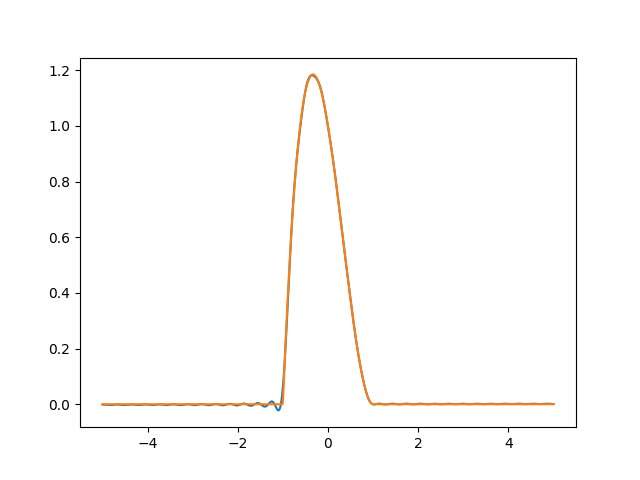

In [10]:
plt.close('all')
plt.plot(xs, ys_no.real)
plt.plot(xs, f0(xs))

/home/pv/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


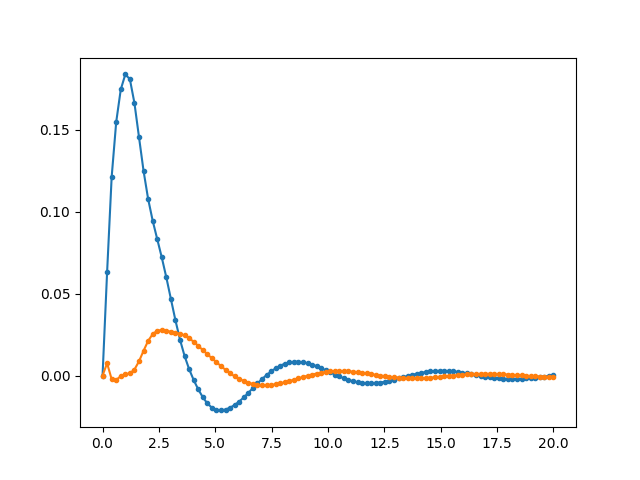

In [11]:
plt.close('all')
plt.plot(Zs, C_As_no, marker='o', markersize=3)
plt.plot(Zs, C_Bs_no, marker='o', markersize=3)

# Orthogonal

In [20]:
S = np.array([[0, 1], [1, 0]])

xs = np.linspace(-5, 5, 800)
zs = np.linspace( 0, 8, 800)
Ys_o = np.zeros((len(zs), len(xs)), dtype=complex)
ys_o = np.zeros(len(xs), dtype=complex)

Zs = np.linspace(0.00001, 20, 100)

f_As_o = np.zeros_like(Zs,dtype=complex)
f_Bs_o = np.zeros_like(Zs,dtype=complex)
C_As_o = np.zeros_like(Zs,dtype=complex)
C_Bs_o = np.zeros_like(Zs,dtype=complex)

dZ = Zs[1] - Zs[0]

for i,Z in enumerate(Zs):
    
    Fa = A.fields(Z, Z_plane=True, mode_type='radiation')
    Fb = A.fields(Z, Z_plane=True, mode_type='radiation', sign='-1')
    
    Ca = A.coefficients(Z, Z_plane=True, mode_type='radiation').T
    Cb = A.coefficients(Z, Z_plane=True, mode_type='radiation', sign='-1').T
        
    Naa = (Ca[0].T @ S @ Ca[0] + Ca[-1].T @ S @ Ca[-1])
    Nbb = (Cb[0].T @ S @ Cb[0] + Cb[-1].T @ S @ Cb[-1])
    Nab = (Ca[0].T @ S @ Cb[0] + Ca[-1].T @ S @ Cb[-1])
    detN = (Naa * Nbb - Nab**2)

    f_A = quad(lambda x: f0(x) * Fa(x), -1, 1,  complex_func=True)[0]
    f_B = quad(lambda x: f0(x) * Fb(x), -1, 1,  complex_func=True)[0]
    
    C_A = 1/(np.pi*detN) * (f_A * Nbb - f_B * Nab) 
    C_B = 1/(np.pi*detN) * (-f_A * Nab + f_B * Naa)
    
    f_As_o[i], f_Bs_o[i] = f_A, f_B
    C_As_o[i], C_Bs_o[i] = C_A, C_B

    Ys_o += (C_A * Fa(xs, zs) + C_B * Fb(xs, zs))* dZ
    ys_o += (C_A * Fa(xs) + C_B * Fb(xs))* dZ
    
    # Ys_o += 1/2*(f_A * Fa(xs, zs)  + f_B * Fb(xs, zs))* dZ
    # ys_o += 1/2*(f_A * Fa(xs) +  f_B * Fb(xs))* dZ

Ys_o += alpha * Fg(xs, zs)
ys_o += alpha * Fg(xs)

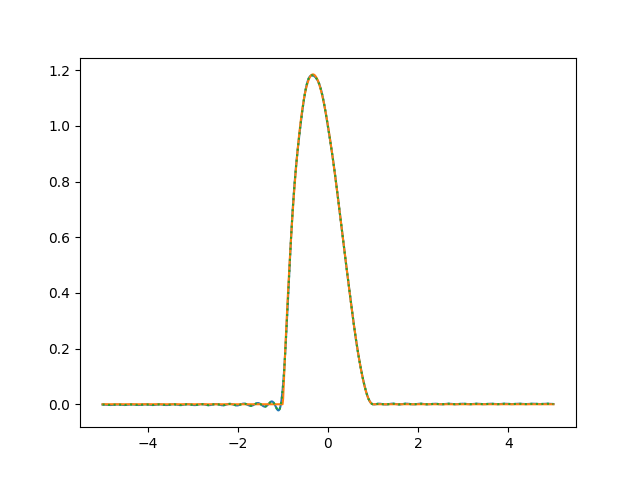

In [21]:
plt.close('all')
plt.plot(xs, ys_o.real)
plt.plot(xs, f0(xs))

plt.plot(xs, ys_no.real, ':')



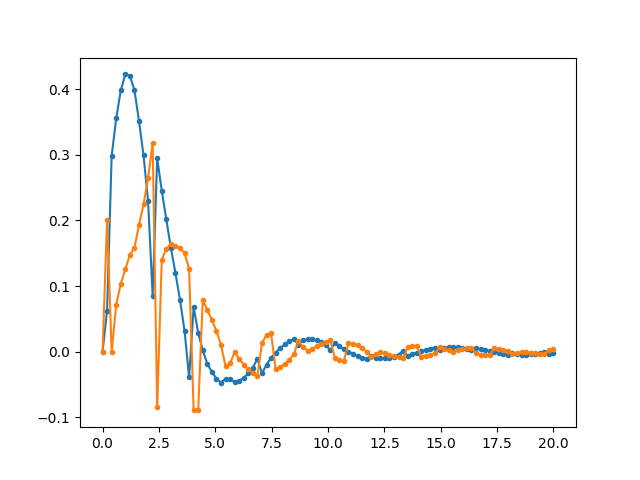

In [22]:
plt.close('all')
plt.plot(Zs, C_As_o, marker='o', markersize=3)
plt.plot(Zs, C_Bs_o, marker='o', markersize=3)

## Alternate Normalization

In [23]:
S = np.array([[0, 1], [1, 0]])

xs = np.linspace(-5, 5, 800)
zs = np.linspace( 0, 8, 800)
Ys_o = np.zeros((len(zs), len(xs)), dtype=complex)
ys_o = np.zeros(len(xs), dtype=complex)

Zs = np.linspace(0.00001, 20, 100)

f_As_o = np.zeros_like(Zs,dtype=complex)
f_Bs_o = np.zeros_like(Zs,dtype=complex)
C_As_o = np.zeros_like(Zs,dtype=complex)
C_Bs_o = np.zeros_like(Zs,dtype=complex)

dZ = Zs[1] - Zs[0]

for i,Z in enumerate(Zs):
    
    Fa = A.fields(Z, Z_plane=True, paper_method=False, mode_type='radiation')
    Fb = A.fields(Z, Z_plane=True, paper_method=False, mode_type='radiation', sign='-1')
    
    Ca = A.coefficients(Z, Z_plane=True, paper_method=False, mode_type='radiation').T
    Cb = A.coefficients(Z, Z_plane=True, paper_method=False, mode_type='radiation', sign='-1').T
        
    Naa = (Ca[0].T @ S @ Ca[0] + Ca[-1].T @ S @ Ca[-1])
    Nbb = (Cb[0].T @ S @ Cb[0] + Cb[-1].T @ S @ Cb[-1])
    Nab = (Ca[0].T @ S @ Cb[0] + Ca[-1].T @ S @ Cb[-1])
    detN = (Naa * Nbb - Nab**2)

    f_A = quad(lambda x: f0(x) * Fa(x), -1, 1,  complex_func=True)[0]
    f_B = quad(lambda x: f0(x) * Fb(x), -1, 1,  complex_func=True)[0]
    
    C_A = 1/(np.pi*detN) * (f_A * Nbb - f_B * Nab) 
    C_B = 1/(np.pi*detN) * (-f_A * Nab + f_B * Naa)
    
    f_As_o[i], f_Bs_o[i] = f_A, f_B
    C_As_o[i], C_Bs_o[i] = C_A, C_B

    Ys_o += (C_A * Fa(xs, zs) + C_B * Fb(xs, zs))* dZ
    ys_o += (C_A * Fa(xs) + C_B * Fb(xs))* dZ
    
    # Ys_o += 1/2*(f_A * Fa(xs, zs)  + f_B * Fb(xs, zs))* dZ
    # ys_o += 1/2*(f_A * Fa(xs) +  f_B * Fb(xs))* dZ

Ys_o += alpha * Fg(xs, zs)
ys_o += alpha * Fg(xs)

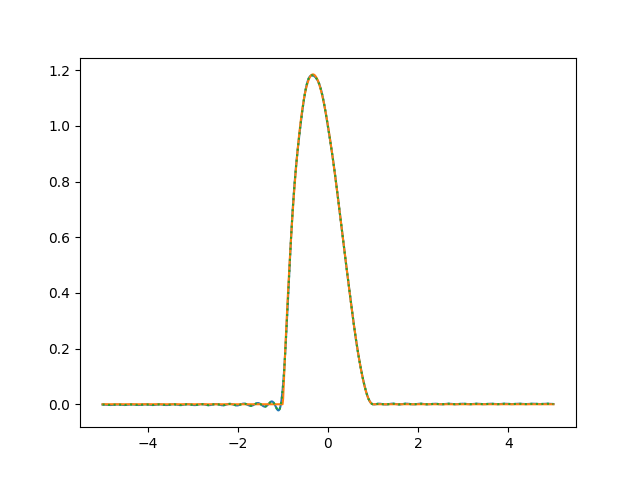

In [24]:
plt.close('all')
plt.plot(xs, ys_o.real)
plt.plot(xs, f0(xs))

plt.plot(xs, ys_no.real, ':')



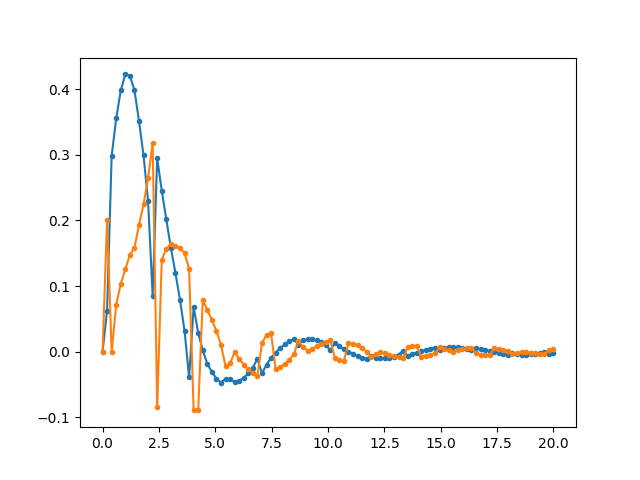

In [25]:
plt.close('all')
plt.plot(Zs, C_As_o, marker='o', markersize=3)
plt.plot(Zs, C_Bs_o, marker='o', markersize=3)